# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE


from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/enduro.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
print(args.exp_name)

WorldModels


In [4]:
print(args.env_name)

Enduro-v0


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [6]:
filelist = os.listdir(DATA_DIR)

In [7]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [8]:
obs.shape

(4445, 100, 100, 3)

In [9]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 100, 100, 3)

In [10]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

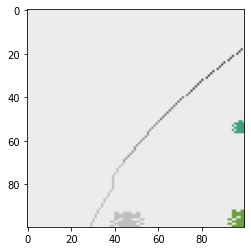

In [11]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [12]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 1.0811 -0.9402 -0.1026  0.4394  0.7922  1.7875  0.0683  1.0284  0.0819  1.8796  0.0339 -0.6012
  1.0598 -1.9821  1.3761 -0.1573  0.5728  0.6197 -1.0448 -0.0364 -1.2017  0.0503  0.5852 -0.1934
 -0.7929 -1.0171 -0.5118 -0.414  -1.6574  0.0398 -0.5982  0.279   0.6008  1.8733  0.6106 -0.2962
 -0.4195 -0.4405 -0.094   0.3463  0.4311  1.0318  0.5143  0.2084  0.3008  1.479  -0.7066  0.4263
 -0.2238 -1.0315  1.4375  0.5527  0.615   0.335   0.6722  0.2086 -1.0289 -0.3259 -1.9258  0.4468
  0.5763  0.9296  1.8996 -1.3051], shape=(64,), dtype=float32)


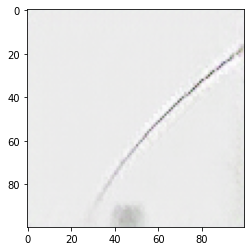

In [13]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

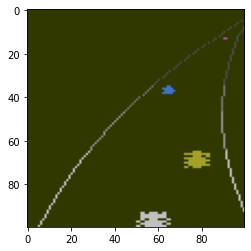

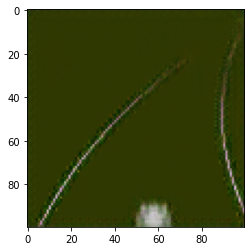

In [69]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 100, 100, 3)
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()
batch_z = vae.encode(frame)
reconstruct = vae.decode(batch_z)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Sample the VAE

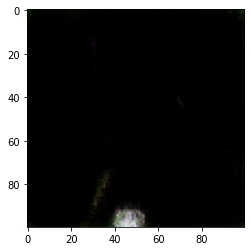

In [15]:
np.random.seed(65)
sample = np.random.rand(64).reshape(-1, 64)
reconstruct = vae.decode(sample)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

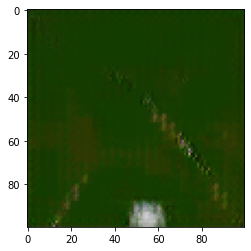

In [42]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()